# Websocket data analysis
Author: Pedro Jesus

Company: Marionete

Email: pedro.jesus\_at\_marionete.co.uk

# Problem

We have a data source which is a websocket containing wikipedia edits. We are going to analyse user actions, and in particular abusive actions triggered by their actions.

In [2]:
%matplotlib inline

from websocket import create_connection
import re
import json
import time
import datetime
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, Math, Markdown

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## Getting data
Data is generated by wikipedia edits through a websocket. Since this data doesn't have a timestamp, one was generated with each message received from the websocket. Data was obtained with the following code:

In [ ]:
def get_current_date():
    return datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')

ws = create_connection("ws://wikimon.hatnote.com:9000")
event_list = list()

t_end = time.time() + 24*60*60 #run for n * 60 seconds
t_previous = time.time()
t_current = time.time()

while t_current < t_end:
    received = ws.recv()
    if t_current > t_previous + 60: #To check if it is still working
        print("Date: '%s', Message: '%s'" % (get_current_date(),received))
        t_previous = time.time()
    event_list.append((get_current_date(),received)) #interested in time of event
    t_current = time.time()

In [ ]:
pickle_file = open(“wikimon_data.pkl”,“wb”)
event_list.dump(event_list, pickle_file)

Since this data takes a while to generate, it can be previously generated and then fetched with the following code:

In [3]:
event_list = pd.read_pickle("wikimon_data.pkl")

## Preprocessing data
Now to convert this input list of json strings and timedates to a pandas Dataframe called `event_df`.

In [4]:
list_json_date = map(
    lambda (date,text): json.loads(text), 
    event_list)

event_df = pd.DataFrame(list_json_date)

In [6]:
display(Markdown('Data has %d rows and %d columns.' % (event_df.shape[0], event_df.shape[1])))

Data has 77219 rows and 18 columns.

In [7]:
display(Markdown('We have the following columns: %s.' % ', '.join(event_df.columns.values)))

We have the following columns: action, change_size, flags, geo_ip, hashtags, is_anon, is_bot, is_minor, is_new, is_unpatrolled, mentions, ns, page_title, parent_rev_id, rev_id, summary, url, user.

## Users

We shall divide the users into four categories ("user_type"): 
 - annonymous users: where `"is_anon" == True`
 - bot: `"is_bot" == True`
 - new users: human users where its account was created during the data generating period, i.e., there is an entry where user has an `"action" == "create"`.
 - regular users: human users already with an account

In [8]:
new_users = event_df[event_df["action"] == "create"]["user"].unique()

In [9]:
def generate_user_type(row):
    if row["user"] in new_users:
        return "new"
    elif row["is_anon"]:
        return "annonymous"
    elif row["is_bot"]:
        return "bot"
    else: 
        return "regular" 
    
event_df["user_type"] = event_df.apply(generate_user_type, axis = 1)    

Plotting user activity:

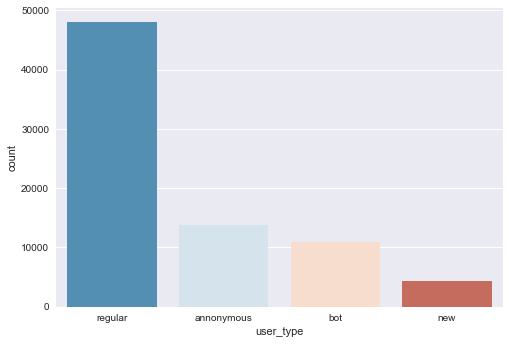

In [10]:
sns.countplot(x = "user_type", data = event_df, 
              palette = sns.color_palette("RdBu_r", 4))

We see there is much more activity from regular users than from annonymous users. Now taking a closer look at each action by each user_type:

In [11]:
actions_per_user = pd.DataFrame(event_df.groupby(["action","user_type"]).size()) #prettify table
actions_per_user.columns = ["Count"]
actions_per_user

Count
action       user_type        
approve      regular        37
autopromote  regular        13
block        regular       389
byemail      new             4
             regular         1
config       regular         2
create       new          1994
create2      new            16
delete       regular       532
delete_redir regular        29
edit         annonymous  11636
             bot         10940
             new          1700
             regular     45045
event        regular         4
hit          annonymous   2227
             new           632
             regular       484
modify       regular         3
move         regular       319
move_redir   regular        29
overwrite    regular       182
patrol       regular       205
protect      regular        32
reblock      regular        10
renameuser   regular        11
reset        regular         1
restore      regular         7
reviewed     regular        90
revision     regular        73
rights       regular         4
send         regular         1
skipoptout   regular         1
tag          regular        53
thank        new            19
             regular       408
unblock      regular         1
unprotect    regular         1
unreviewed   regular         2
upload       regular        82

Here we can already see the permissions for each type of user. *Bots* only "edit", *annonymous* can only "edit" and get "hit", and *new* even though they have the same right as the regular users, they mostly only have "edit" and "hit".
Now we perform a plot with only the most relevant actions:

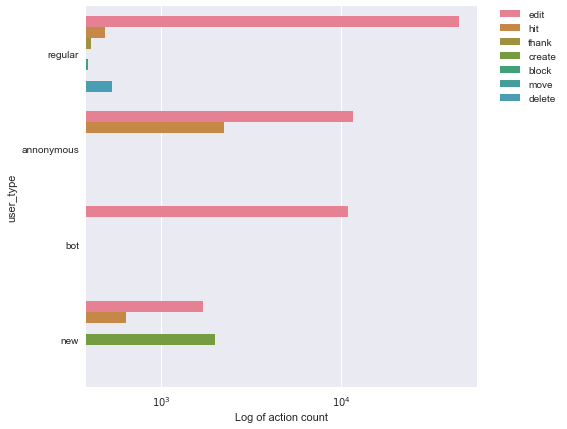

In [12]:
most_relevant_actions_event_df = event_df[event_df["action"].
            isin(["block","create","delete","edit","hit","move","thank"])]

f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log")
sns.countplot(data = most_relevant_actions_event_df, 
              y = "user_type", hue = "action",
              palette = sns.color_palette("husl", 10), ax = ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Log of action count")

"hit" action happens more with annonymous and new users than regular, lets analyse this observation with more detail.

## "hit" action
"hit" action's "summary" follows the pattern: 

```
`user` triggered [[Special:AbuseFilter/`...`]], performing the action `"..."` on `[[...]]`. Actions taken: ... ([[Special:AbuseLog`...`]])
```

From this we can infer that the user, the action that caused the abuse and what action was taken. Now we focus on the user and action performed, to check which types of "hit" each user triggers.

In [13]:
hit_rows = event_df[event_df['action'] == 'hit'].index
event_hits = event_df.loc[hit_rows,:]

In [14]:
#Fetch type of action of the hit
hit_regex = re.compile('(?<=performing the action \").*(?=\" on )')
event_hits["hit_action"] = event_hits["summary"].apply(
    lambda x: hit_regex.findall(x)[0])

And now lets compare each hit with each type of user:

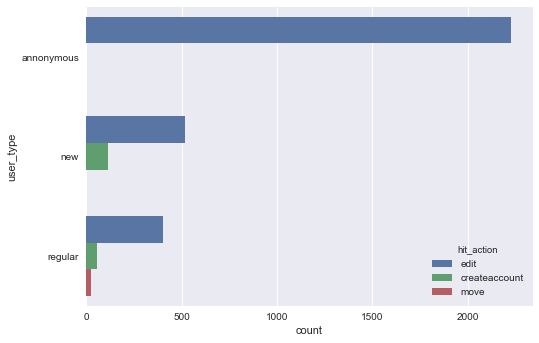

In [15]:
sns.countplot(data = event_hits, y = "user_type", hue = "hit_action")

A very interesting conclusion can be made here:

Even though there is more edit activity from regular users than annonymous users, the annonymous users are responsible for most of the edit "hit"s. And even newcomers raise more hits than regulars.  

This may be because annonymous tend to be more rebellious than regular users that try to be inside the rules. And newcomers are unexperienced and still raise some flags.